In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from cleaning import *

In [4]:
FILEPATH = "selected_df - All.csv"
df = pd.read_csv(FILEPATH,
                 index_col=0,
                 header=[1]).reset_index()
df.head()

,index,titles,ratings,reviewer,reviews,english,dates,replies,reply_dates,clean_review,...,Carrefour,Other brand,reimbursement,clean_BE,clean_PD,clean_DM,clean_AS,summary,top_3,proper_n
0,1,Mais ou est ma commande???,1,todo,"Commande N° 609249735,toujours non livrée,pass...",NaN,2023-02-07T17:39:04.000Z,"Bonjour, nous vous informons que nous avons pr...",2023-02-08T09:48:06.000Z,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Cela fait plusieurs semaines même plus…,1,todo,Magasin de Carrefour Trans en Provence 83\nCel...,NaN,2023-02-06T14:48:53.000Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Commande Deliveroo annulé !,1,todo,Commande Deliveroo passé ce jour sans suite ca...,NaN,2023-02-08T10:54:56.000Z,"Bonjour, Pouvez-vous nous communiquer vos prén...",2023-02-08T10:17:23.000Z,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,une honte cette société qu'utilise…,1,todo,une honte cette société qu'utilise Carrefour p...,NaN,2023-02-04T18:29:49.000Z,"Bonjour, pourriez-vous nous communiquer votre ...",2023-02-05T08:17:54.000Z,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Nous sommes passer en caisse N,1,todo,Nous sommes passer en caisse N : 12\n28/01/202...,NaN,2023-02-05T14:36:40.000Z,"Bonjour, Pouvez-vous nous préciser le magasin ...",2023-02-06T08:30:25.000Z,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Original shape: (2000, 36)
Selected shape: (276, 36)
Unselected shape: (1724, 36)


/Users/carlosito/Library/CloudStorage/OneDrive-Personal/Personal Document/Hexamind/hexamind_code/Carrefour/Clustering/OneShotClassifier/cleaning.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['clean_BE'] = np.any(selected_df.loc[: ,BE_subclass], axis=1)
/Users/carlosito/Library/CloudStorage/OneDrive-Personal/Personal Document/Hexamind/hexamind_code/Carrefour/Clustering/OneShotClassifier/cleaning.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['clean_PD'] = np.any(selected_

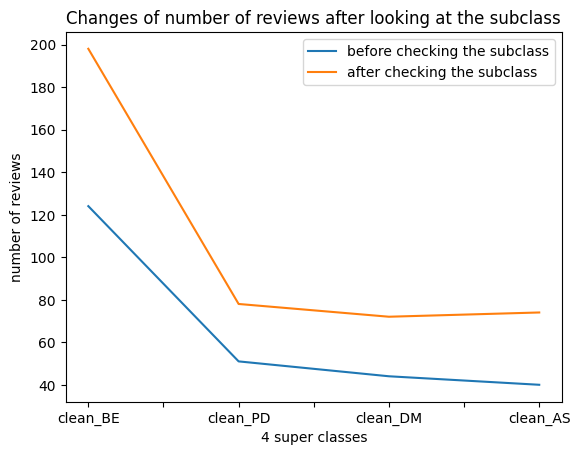

In [5]:
label_df, unlabel_df = binary_transform(df)

In [6]:
print(label_df.shape)
print(unlabel_df.shape)

(276, 36)
(1724, 36)


# 2/3 Train Test split

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix, f1_score, accuracy_score, hamming_loss


from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import LogisticRegression

In [8]:
X = label_df.combined_reviews
y = label_df.loc[: , ['clean_BE' , 'clean_PD', 'clean_DM', 'clean_AS']]

In [9]:
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y,
                                                              train_size=0.7,
                                                              random_state=42)

In [10]:
count_vectorizer = CountVectorizer(analyzer='word',
                                   lowercase=False,
                                   max_df= 20)
X_train = count_vectorizer.fit_transform(X_train_text)
X_test = count_vectorizer.transform(X_test_text)

print(X_train.shape, X_test.shape)

(193, 3620) (83, 3620)


In [11]:
X_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
from sklearn.model_selection import GridSearchCV
parameters = {'penalty': [None, 'l2'], 
              'class_weight': [None, 'balanced']}


clf = GridSearchCV(MultiOutputClassifier(LogisticRegression(), 
                                         param_grid = parameters,
                                         scoring='f1_macro'))


TypeError: MultiOutputClassifier.__init__() got an unexpected keyword argument 'param_grid'

In [99]:
clf = MultiOutputClassifier(LogisticRegression()).fit(X_train, y_train)

In [100]:
prediction = clf.predict(X_test)
print(classification_report(y_true = y_test,
                            y_pred = prediction))
print(accuracy_score(y_true = y_test,
                      y_pred = prediction))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84        63
           1       0.67      0.18      0.29        22
           2       0.71      0.25      0.37        20
           3       0.86      0.26      0.40        23

   micro avg       0.76      0.58      0.65       128
   macro avg       0.75      0.41      0.47       128
weighted avg       0.75      0.58      0.59       128
 samples avg       0.75      0.64      0.66       128

0.42168674698795183


/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
print(multilabel_confusion_matrix(y_true = y_test,
                      y_pred = prediction))

[[[ 1 19]
  [ 4 59]]

 [[59  2]
  [18  4]]

 [[61  2]
  [15  5]]

 [[59  1]
  [17  6]]]


In [114]:
clf = ClassifierChain(LogisticRegression()).fit(X_train, y_train)
prediction = clf.predict(X_test)
print(classification_report(y_true = y_test,
                            y_pred = prediction))
print(accuracy_score(y_true = y_test,
                      y_pred = prediction))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84        63
           1       0.60      0.14      0.22        22
           2       0.71      0.25      0.37        20
           3       0.83      0.22      0.34        23

   micro avg       0.75      0.56      0.64       128
   macro avg       0.73      0.39      0.44       128
weighted avg       0.74      0.56      0.57       128
 samples avg       0.75      0.62      0.65       128

0.42168674698795183


/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [124]:
clf = ClassifierChain(RandomForestClassifier(max_depth = 10,
                                             max_features = 'log2')).fit(X_train, y_train)
prediction = clf.predict(X_test)
print(classification_report(y_true = y_test,
                            y_pred = prediction))
print(accuracy_score(y_true = y_test,
                      y_pred = prediction))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86        63
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        23

   micro avg       0.76      0.49      0.60       128
   macro avg       0.19      0.25      0.22       128
weighted avg       0.37      0.49      0.42       128
 samples avg       0.76      0.58      0.63       128

0.4457831325301205


/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Now will try to plot that curve

In [13]:
n_samples = [8, 16, 32, 64 , 128, 193]

f1_score_record = []
accuracy_record = []
hamming_loss_record = []
for n in n_samples:
    selected_X_train_text = X_train_text[: n] #slice the training text based on the batch size
    count_vectorizer = CountVectorizer(analyzer='word', #call new countVectorizer
                                   lowercase=False,
                                   max_df= 20)
    selected_X_train = count_vectorizer.fit_transform(selected_X_train_text) 
    selected_X_test = count_vectorizer.transform(X_test_text) #this will be always 83
    assert selected_X_test.shape[0] == 83
    
    selected_y_train = y_train[:n]
    
    clf = MultiOutputClassifier(LogisticRegression()).fit(selected_X_train, selected_y_train)
    
    prediction = clf.predict(selected_X_test)
    
    f1_score_record.append(f1_score(y_true = y_test,
                                    y_pred = prediction,
                                    average = 'macro'))
    
    accuracy_record.append(accuracy_score(y_true = y_test,
                                    y_pred = prediction))
    
    hamming_loss_record.append(hamming_loss(y_true = y_test,
                                    y_pred = prediction))
    
    
    

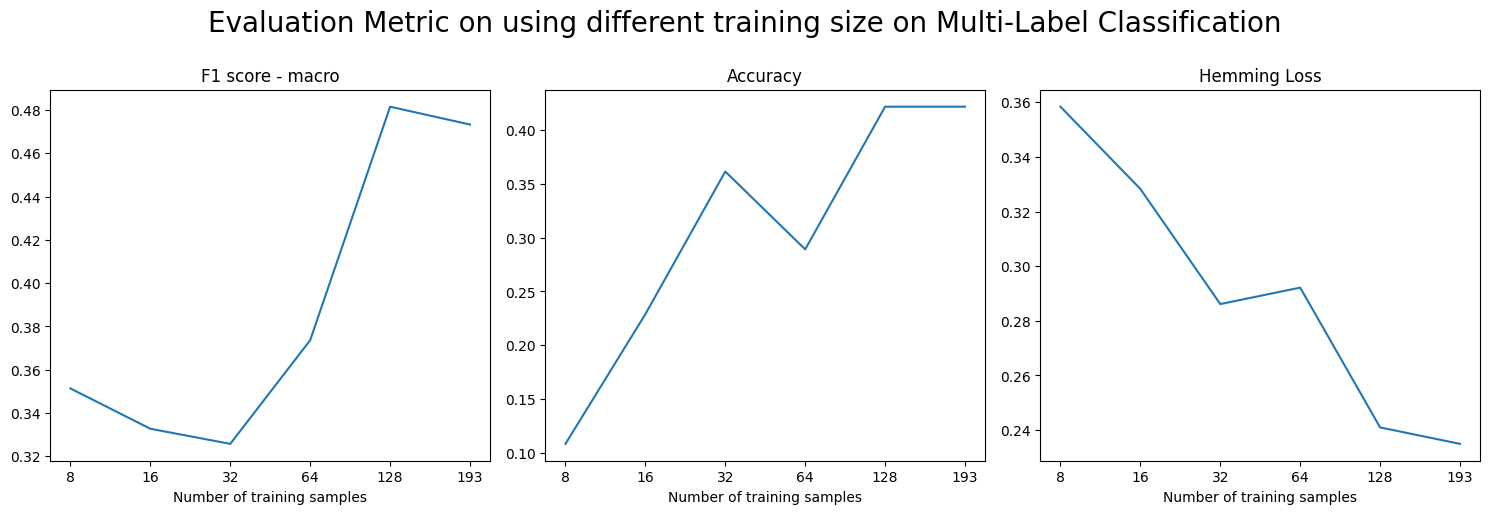

In [14]:
fig, axes = plt.subplots(1,3, figsize = (15,5))

sns.lineplot(data = f1_score_record,
             ax = axes[0])

sns.lineplot(data = accuracy_record,
             ax = axes[1])

sns.lineplot(data = hamming_loss_record,
             ax = axes[2])

fig.suptitle('Evaluation Metric on using different training size on Multi-Label Classification\n',
             fontsize = 20)
fig.tight_layout()

axes[0].set_title('F1 score - macro')
axes[1].set_title('Accuracy')
axes[2].set_title('Hemming Loss')

axes[0].set_xlabel('Number of training samples')
axes[1].set_xlabel('Number of training samples')
axes[2].set_xlabel('Number of training samples')

axes[0].set_xticks(range(6), n_samples )
axes[1].set_xticks(range(6), n_samples )
axes[2].set_xticks(range(6), n_samples )
plt.show()

In [15]:
print(classification_report(y_true = y_test,
                            y_pred = prediction))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84        63
           1       0.67      0.18      0.29        22
           2       0.71      0.25      0.37        20
           3       0.86      0.26      0.40        23

   micro avg       0.76      0.58      0.65       128
   macro avg       0.75      0.41      0.47       128
weighted avg       0.75      0.58      0.59       128
 samples avg       0.75      0.64      0.66       128



/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---

## Use CountVectorizer without stopwords

In [21]:
# opening the file in read mode
my_file = open("/Users/carlosito/Library/CloudStorage/OneDrive-Personal/Personal Document/Hexamind/hexamind_code/Carrefour/french_stopword.txt" , 'r')
  
# reading the file
data = my_file.read()
  
# replacing end of line('/n') with ' ' and
# splitting the text it further when '.' is seen.
french_stopwords_list = data.replace('\n', ' ').split(" ")
  
# # printing the data
print(french_stopwords_list[:5])
my_file.close()

['a', 'abord', 'absolument', 'afin', 'ah']


In [29]:
n_samples = [8, 16, 32, 64 , 128, 193]

f1_score_record_without_stopword = []
accuracy_record_without_stopword = []
hamming_loss_record_without_stopword = []
for n in n_samples:
    selected_X_train_text = X_train_text[: n] #slice the training text based on the batch size
    count_vectorizer = CountVectorizer(analyzer='word', #call new countVectorizer
                                   lowercase=True,
                                   stop_words= french_stopwords_list )
    selected_X_train = count_vectorizer.fit_transform(selected_X_train_text) 
    selected_X_test = count_vectorizer.transform(X_test_text) #this will be always 83
    assert selected_X_test.shape[0] == 83
    
    selected_y_train = y_train[:n]
    
    clf = MultiOutputClassifier(LogisticRegression()).fit(selected_X_train, selected_y_train)
    
    prediction = clf.predict(selected_X_test)
    
    f1_score_record_without_stopword.append(f1_score(y_true = y_test,
                                    y_pred = prediction,
                                    average = 'macro'))
    
    accuracy_record_without_stopword.append(accuracy_score(y_true = y_test,
                                    y_pred = prediction))
    
    hamming_loss_record_without_stopword.append(hamming_loss(y_true = y_test,
                                    y_pred = prediction))
    

/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  warnings.warn(
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  warnings.warn(
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  warnings.warn(
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarn

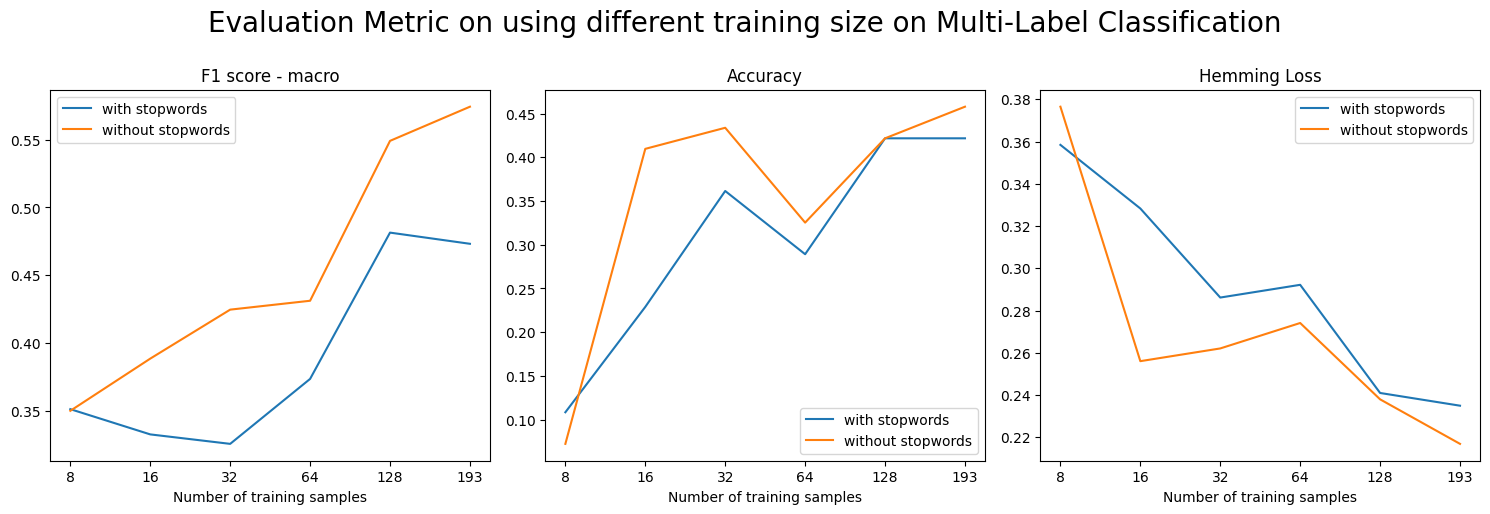

In [33]:
fig, axes = plt.subplots(1,3, figsize = (15,5))

sns.lineplot(data = f1_score_record,
             ax = axes[0], label = 'with stopwords')

sns.lineplot(data = accuracy_record,
             ax = axes[1], label = 'with stopwords')

sns.lineplot(data = hamming_loss_record,
             ax = axes[2], label = 'with stopwords')


sns.lineplot(data = f1_score_record_without_stopword,
             ax = axes[0], label = 'without stopwords')

sns.lineplot(data = accuracy_record_without_stopword,
             ax = axes[1], label = 'without stopwords')

sns.lineplot(data = hamming_loss_record_without_stopword,
             ax = axes[2], label = 'without stopwords')


fig.suptitle('Evaluation Metric on using different training size on Multi-Label Classification\n',
             fontsize = 20)
fig.tight_layout()

axes[0].set_title('F1 score - macro')
axes[1].set_title('Accuracy')
axes[2].set_title('Hemming Loss')

axes[0].set_xlabel('Number of training samples')
axes[1].set_xlabel('Number of training samples')
axes[2].set_xlabel('Number of training samples')

axes[0].set_xticks(range(6), n_samples )
axes[1].set_xticks(range(6), n_samples )
axes[2].set_xticks(range(6), n_samples )
plt.show()

In [32]:
print(classification_report(y_true = y_test,
                            y_pred = prediction))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83        63
           1       0.67      0.36      0.47        22
           2       0.77      0.50      0.61        20
           3       0.75      0.26      0.39        23

   micro avg       0.77      0.62      0.69       128
   macro avg       0.75      0.50      0.57       128
weighted avg       0.76      0.62      0.66       128
 samples avg       0.75      0.66      0.67       128



/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
summary_df = pd.DataFrame( [ ["a" ,"b","c", "d"] , prediction.sum(axis = 0) , ['prediction without stopwords' for i in range(4)]]).T
summary_df.columns = ['class_name', 'count', 'type']

y_test_summary_df = pd.DataFrame( [ ["a" ,"b","c", "d"] , y_test.sum(axis = 0) , ['y_test' for i in range(4)]]).T
y_test_summary_df.columns = ['class_name', 'count', 'type']


In [77]:
y_test_summary_df

,class_name,count,type
0,a,63,y_test
1,b,22,y_test
2,c,20,y_test
3,d,23,y_test


In [78]:
test_plot = pd.concat([summary_df, y_test_summary_df])
test_plot

,class_name,count,type
0,a,69,prediction without stopwords
1,b,12,prediction without stopwords
2,c,13,prediction without stopwords
3,d,8,prediction without stopwords
0,a,63,y_test
1,b,22,y_test
2,c,20,y_test
3,d,23,y_test


<AxesSubplot: xlabel='class_name', ylabel='count'>

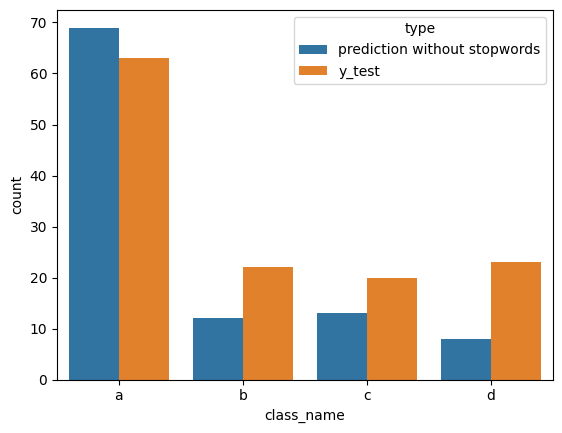

In [79]:
sns.barplot(data=test_plot, x= 'class_name', y ='count', hue = 'type')

In [17]:
BE_count = CountVectorizer()
label_df[label_df['clean_BE'] == 1]

,index,titles,ratings,reviewer,reviews,english,dates,replies,reply_dates,clean_review,...,Carrefour,Other brand,reimbursement,clean_BE,clean_PD,clean_DM,clean_AS,summary,top_3,proper_n
10,11,Autant l'hyper de ma ville est plus…,3,Poon,"Autant l'hyper de ma ville est plus complet, a...","As much the hyper of my city is more complete,...",2023-01-28T22:00:47.000Z,"Bonjour, effectivement, vos magasins de proxim...",2023-01-31T12:22:09.000Z,"Autant l'hyper de ma ville est plus complet, a...",...,False,False,False,1,0,0,0,NaN,NaN,NaN
14,15,Carrefour France,3,Poon,"Carrefour France, vous choisissez de mettre e...","Carrefour France, you choose to set up boxes w...",2023-01-25T11:25:11.000Z,"Bonjour, pourriez-vous nous communiquer plus d...",2023-01-25T12:44:28.000Z,"Carrefour France, vous choisissez de mettre e...",...,False,False,False,1,0,0,0,NaN,NaN,NaN
16,17,Carrefour Grand Var,2,Yves,Carrefour Grand Var : cela fait quelques moi q...,NaN,2023-01-17T05:00:41.000Z,"Bonjour, nous vous remercions pour votre signa...",2023-01-17T15:05:55.000Z,Carrefour Grand Var : cela fait quelques moi q...,...,False,False,False,1,0,0,0,NaN,NaN,NaN
19,20,Carrefour market très bien mais il…,3,Poon,Carrefour market Miramas très bien mais il n'e...,Carrefour Market Miramas very well but it is n...,2023-01-21T06:31:51.000Z,"Bonsoir, pourriez-vous nous apporter plus de p...",2023-01-21T07:55:55.000Z,Carrefour market Miramas très bien mais il n'e...,...,False,False,False,1,0,0,0,NaN,NaN,NaN
21,22,PUBLICITE MENSONGERE,1,Yves,je reçois ce matin un sms de carrefour me disa...,NaN,2023-01-12T08:29:08.000Z,"Bonjour, afin d'expertiser cette situation, no...",2023-01-13T14:48:32.000Z,je reçois ce matin un sms de carrefour me disa...,...,False,False,False,1,0,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961,1962,Aucun contact possible avec le SAV,1,Insaf,À l'heure ou j'écris j'en suis au 5eme appel c...,NaN,2014-09-12T14:27:00.000Z,NaN,NaN,À l'heure ou j'écris j'en suis au 5eme appel c...,...,True,False,False,1,0,1,1,NaN,NaN,NaN
1964,1965,"Publicité mensongère, site online inacceptable...",1,Insaf,des expériences similaires à la mienne ont déj...,NaN,2014-09-05T19:59:34.000Z,NaN,NaN,des expériences similaires à la mienne ont déj...,...,True,False,False,1,1,1,1,NaN,NaN,NaN
1968,1969,Produit défectueux et SAV lamentable,1,Insaf,J'ai reçu un produit défectueux et le SAV refu...,NaN,2014-08-07T10:04:22.000Z,NaN,NaN,J'ai reçu un produit défectueux et le SAV refu...,...,False,False,True,1,1,0,1,NaN,NaN,NaN
1972,1973,"inacceptable, mauvais service après-vente",1,All,Je fais toutes mes courses chaque semaine à ca...,NaN,2014-06-12T09:45:37.000Z,NaN,NaN,Je fais toutes mes courses chaque semaine à ca...,...,True,False,False,1,0,0,1,NaN,NaN,NaN
